In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
df1 = pd.read_csv('GooglePlay.csv', index_col=False)
df2 = pd.read_csv('Playstore_final.csv', low_memory=False, index_col=False)

In [42]:
# MERGE BASE ON APP NAME
merged = pd.merge(df1, df2, left_on="App", right_on="App Name", how="inner")

In [43]:
# merged.to_csv('After_merge.csv' , index=False)

In [44]:
# CLEAN THE 'INSTALLS' COLUMN: REMOVE '+' AND ',' AND CONVERT TO INT
def clean_installs(installs):
    if isinstance(installs, str):
        installs = installs.replace(',', '').replace('+', '').strip()
        try:
            return int(installs)
        except ValueError:
            return np.nan  


df1['Installs'] = df1['Installs'].apply(clean_installs)
df2['Installs'] = df2['Installs'].apply(clean_installs)

# CLEAN THE 'SIZE' COLUMN: REMOVE 'M' AND 'k', CONVERT TO FLOAT
def clean_size(size):
    if isinstance(size, str):
        size = size.strip().replace('M', '').replace('k', '').replace(',', '')
    return size
    
df1['Size'] = df1['Size'].apply(clean_size)
df2['Size'] = df2['Size'].apply(clean_size)

merged = pd.merge(df1, df2, left_on="App", right_on="App Name", how="inner")

numeric_columns = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']  
object_columns = ['Category', 'Content Rating']  

for col in numeric_columns:
    merged[col + '_x'] = pd.to_numeric(merged[col + '_x'], errors='coerce')
    merged[col + '_y'] = pd.to_numeric(merged[col + '_y'], errors='coerce')

def combine_numeric_columns(row, col_x, col_y):
    if pd.notna(row[col_x]) and pd.notna(row[col_y]):
        if row[col_x] == row[col_y]:
            return row[col_x]
        else:
            return (row[col_x] + row[col_y]) / 2
    elif pd.notna(row[col_x]):
        return row[col_x]
    else:
        return row[col_y]

def combine_object_columns(row, col_x, col_y):
    if row[col_x] == row[col_y]:
        return row[col_x]
    else:
        return row[col_x] if pd.notna(row[col_x]) else row[col_y]

for col in numeric_columns:
    col_x = col + '_x'
    col_y = col + '_y'
    merged[col] = merged.apply(lambda row: combine_numeric_columns(row, col_x, col_y), axis=1)
    merged.drop([col_x, col_y], axis=1, inplace=True)


for col in object_columns:
    col_x = col + '_x'
    col_y = col + '_y'
    merged[col] = merged.apply(lambda row: combine_object_columns(row, col_x, col_y), axis=1)
    merged.drop([col_x, col_y], axis=1, inplace=True)

merged.drop(['Type'] , axis=1 , inplace=True)
merged.drop(['App Name'] , axis=1 , inplace=True)


# DROP UNNAMED COLUMNS
unnamed_columns = [col for col in merged.columns if "Unnamed" in col]
merged.drop(columns=unnamed_columns, inplace=True)

merged['Free'] = np.where(merged['Price'] == 0, 'True', 'False')

#### COMBINE LAST UPDATE COLUMNS

merged['Last Updated'] = merged.apply(lambda row: row['Last Updated'] if row['Last Updated'] == row['Last update'] else row['Last update'], axis=1)
merged.drop('Last update', axis=1, inplace=True)

#### COMBINE VERSION COLUMNS

merged['Current Ver'] = merged.apply(lambda row: row['Version'] if row['Current Ver'] == row['Version'] else row['Version'], axis=1)
merged.drop('Version', axis=1, inplace=True)

######COMBINE ANDROID VERSION COLUMNS

merged['Android Ver'] = merged.apply(lambda row: row['Android Ver'] if row['Android Ver'] == row['Android version Text'] else row['Android version Text'], axis=1)
merged.drop('Android version Text', axis=1, inplace=True)
 
###### ADD AN EXTRA COLUMN 
merged['Number of satisfied users'] = ((merged['Rating Count']*merged['Rating']/5).fillna(0)).astype(int)

####

merged['Rating'] = round(merged['Rating'], 2)


In [45]:
# merged.to_csv('Clean_and_combine.csv' , index=False)

In [46]:
#######FILLING MISSED VALUES
for col in merged.columns:
    if merged[col].dtype == 'object':
        # Fill categorical columns with mode
        merged[col].fillna(merged[col].mode()[0], inplace=True)
    else:
        # Fill numeric columns with mean
        merged[col].fillna(merged[col].mean(), inplace=True)


In [47]:
# merged.to_csv('Handle_missing_values.csv' , index=False)


In [48]:
###NORMALIZE NUMERIC COLUMNS WITH MINMAX SKAILING

columns_to_normalize = ['Rating', 'Rating Count', 'Size', 'Installs', 'Reviews' ]

normalized_column_names = [col + '_norm' for col in columns_to_normalize]

scaler = MinMaxScaler()

normalized_values = scaler.fit_transform(merged[columns_to_normalize])

normalized_values = np.around(normalized_values, decimals=5)

merged[normalized_column_names] = pd.DataFrame(normalized_values, columns=normalized_column_names)


In [49]:
# merged.to_csv('Normalized_dataset.csv', index=False)

In [50]:
###### REPLACE OUTLIERS WITH MEAN
numeric_columns = ['Rating_norm', 'Size_norm', 'Installs_norm', 'Reviews_norm']

# CALCULATE THE MEAN 
column_means = merged[numeric_columns].mean()

for col in numeric_columns:
    Q1 = merged[col].quantile(0.25)
    Q3 = merged[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (merged[col] < lower_bound) | (merged[col] > upper_bound)
    
    merged.loc[outliers, col] = column_means[col]


In [51]:
# merged.to_csv('Handle_outliers.csv', index=False)

In [52]:
######## DATA REDUCTION
#DROP USELESS COLUMN
columns_to_drop = ['Developer Website', 'Developer Email', 'Privacy Policy' , 'Summary' ]

# DROP
merged.drop(columns=columns_to_drop, inplace=True)


In [53]:
# merged.to_csv('After_drop.csv', index=False)

In [54]:
##### CONVERT NUMERIC TO CATEGORICAL

num_bins = 5

#DEFINE LABELS
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

merged['Rating_bins'] = pd.qcut(merged['Rating'],q=num_bins, labels=labels, duplicates='drop')
merged['Reviews_bins'] = pd.qcut(merged['Reviews'],q=num_bins, labels=labels, duplicates='drop')
merged['Size_bins'] = pd.qcut(merged['Size'], q=num_bins,labels=labels, duplicates='drop')
merged['Installs_bins'] = pd.qcut(merged['Installs'], q=num_bins,labels=labels, duplicates='drop')


In [55]:
# merged.to_csv('dataset.csv', index=False)

In [56]:
#######COMPARE SPORT CATEGORY WITH ALL 

#FILTER SPORT GENER
sports_apps = merged[merged['Genres'] == 'Sports']

##CALC THE MEAN OF RATING FOR SPORT GENER APP
mean_rating_sports = sports_apps['Rating'].mean()

mean_rating_all = merged['Rating'].mean()

print(f"'sports'میانگین رتبه‌بندی اپلیکیشن‌های ژانر : {mean_rating_sports}")
print(f"میانگین کل رتبه‌بندی‌ها: {mean_rating_all}")

# مقایسه آماری
if mean_rating_sports > mean_rating_all:
    print("اپلیکیشن‌های ژانر 'sports' میانگین رتبه‌بندی بالاتری نسبت به کل اپلیکیشن‌ها دارند.")
elif mean_rating_sports < mean_rating_all:
    print("اپلیکیشن‌های ژانر 'sports' میانگین رتبه‌بندی کمتری نسبت به کل اپلیکیشن‌ها دارند.")
else:
    print("میانگین رتبه‌بندی اپلیکیشن‌های ژانر 'sports' با میانگین کل رتبه‌بندی‌ها برابر است.")


'sports'میانگین رتبه‌بندی اپلیکیشن‌های ژانر : 4.169463087248322
میانگین کل رتبه‌بندی‌ها: 4.033083693390942
اپلیکیشن‌های ژانر 'sports' میانگین رتبه‌بندی بالاتری نسبت به کل اپلیکیشن‌ها دارند.


In [17]:
merged.to_csv('dataset.csv', index=False)

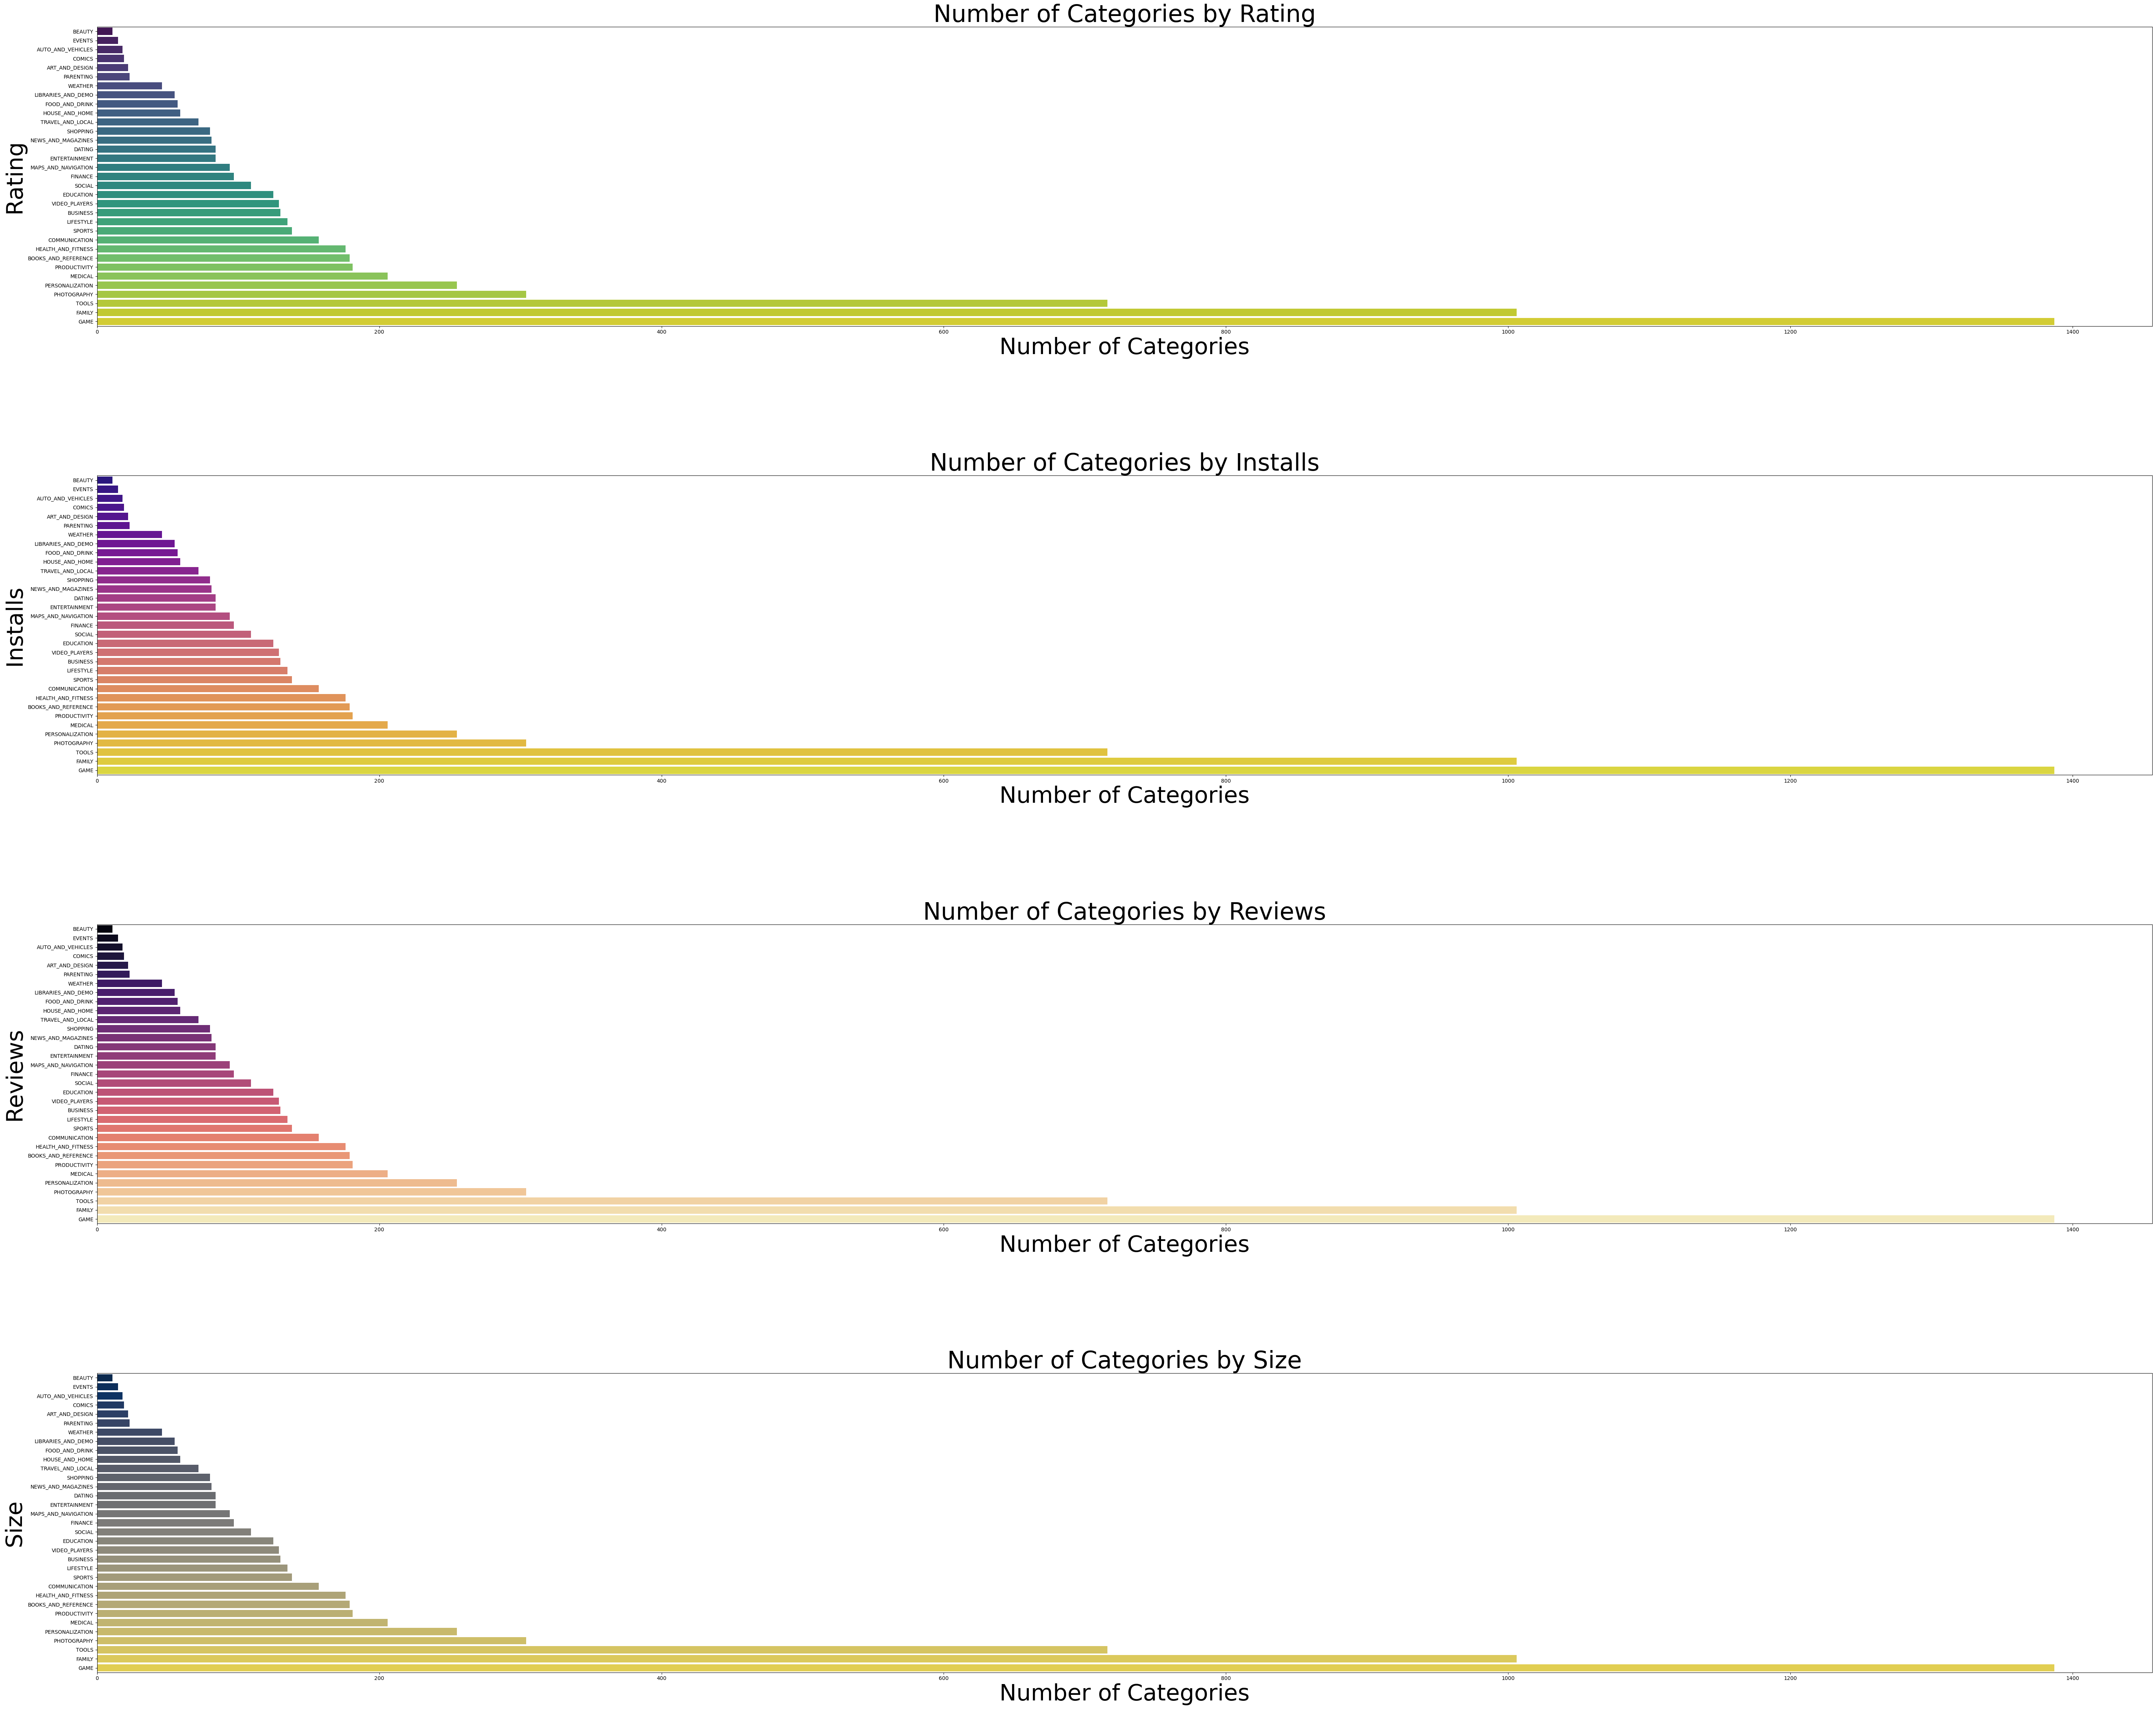

In [39]:
plt.figure(figsize=(58, 46))


def plot_sorted_bar_chart(data, group_column, value_column, title, xlabel, ylabel, palette):
    count_data = data.groupby(group_column).size().sort_values(ascending=True)
    sns.barplot(x=count_data.values, y=count_data.index, palette=palette)
    plt.title(title, fontsize=46)
    plt.xlabel(xlabel, fontsize=44)
    plt.ylabel(ylabel, fontsize=44)

plt.subplot(4, 1, 1)
plot_sorted_bar_chart(merged, 'Category', 'Rating', 'Number of Categories by Rating', 'Number of Categories', 'Rating', 'viridis')

plt.subplot(4, 1, 2)
plot_sorted_bar_chart(merged, 'Category', 'Installs', 'Number of Categories by Installs', 'Number of Categories', 'Installs', 'plasma')

plt.subplot(4, 1, 3)
plot_sorted_bar_chart(merged, 'Category', 'Reviews', 'Number of Categories by Reviews', 'Number of Categories', 'Reviews', 'magma')

plt.subplot(4, 1, 4)
plot_sorted_bar_chart(merged, 'Category', 'Size', 'Number of Categories by Size', 'Number of Categories', 'Size', 'cividis')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  


plt.show()